In [1]:
import pandas as pd
election_data = pd.read_csv("countypres_2000-2020.csv")

# Inspecting columns and cleaning the Election Data
election_data_cleaned = election_data[
    ['year', 'state', 'state_po', 'county_name', 'county_fips', 'candidate', 
     'party', 'candidatevotes', 'totalvotes']
].dropna()

# Renaming columns for clarity and consistency
election_data_cleaned = election_data_cleaned.rename(columns={
    'state_po': 'state_abbreviation',
    'county_fips': 'fips_code',
    'candidatevotes': 'votes_candidate',
    'totalvotes': 'votes_total'
})

# Displaying the first few rows of the cleaned dataset
election_data_cleaned

,year,state,state_abbreviation,county_name,fips_code,candidate,party,votes_candidate,votes_total
0,2000,ALABAMA,AL,AUTAUGA,1001.0,AL GORE,DEMOCRAT,4942,17208
1,2000,ALABAMA,AL,AUTAUGA,1001.0,GEORGE W. BUSH,REPUBLICAN,11993,17208
2,2000,ALABAMA,AL,AUTAUGA,1001.0,RALPH NADER,GREEN,160,17208
3,2000,ALABAMA,AL,AUTAUGA,1001.0,OTHER,OTHER,113,17208
4,2000,ALABAMA,AL,BALDWIN,1003.0,AL GORE,DEMOCRAT,13997,56480
...,...,...,...,...,...,...,...,...,...
72612,2020,WYOMING,WY,WASHAKIE,56043.0,DONALD J TRUMP,REPUBLICAN,3245,4032
72613,2020,WYOMING,WY,WESTON,56045.0,JOSEPH R BIDEN JR,DEMOCRAT,360,3560
72614,2020,WYOMING,WY,WESTON,56045.0,JO JORGENSEN,LIBERTARIAN,46,3560
72615,2020,WYOMING,WY,WESTON,56045.0,OTHER,OTHER,47,3560


In [2]:
# Analyzing election results for each county in each election year

# Group data by year, state, county, and party to calculate total votes by party
county_election_results = election_data_cleaned.groupby(
    ['year', 'state', 'county_name', 'party']
).agg({'votes_candidate': 'sum'}).reset_index()

# Find the winning party for each county in each year
county_election_results['rank'] = county_election_results.groupby(
    ['year', 'state', 'county_name']
)['votes_candidate'].rank(method='max', ascending=False)

# Filter to get only the winning party for each county-year
winning_party_per_county = county_election_results[county_election_results['rank'] == 1].drop(columns=['rank'])

# Sort results for better readability
winning_party_per_county = winning_party_per_county.sort_values(by=['year', 'state', 'county_name'])

winning_party_per_county

,year,state,county_name,party,votes_candidate
3,2000,ALABAMA,AUTAUGA,REPUBLICAN,11993
7,2000,ALABAMA,BALDWIN,REPUBLICAN,40872
8,2000,ALABAMA,BARBOUR,DEMOCRAT,5188
15,2000,ALABAMA,BIBB,REPUBLICAN,4273
19,2000,ALABAMA,BLOUNT,REPUBLICAN,12667
...,...,...,...,...,...
64031,2020,WYOMING,SWEETWATER,REPUBLICAN,12229
64032,2020,WYOMING,TETON,DEMOCRAT,9848
64039,2020,WYOMING,UINTA,REPUBLICAN,7496
64043,2020,WYOMING,WASHAKIE,REPUBLICAN,3245


In [3]:
# Identifying swing counties (counties that changed their winning party between elections)

# Create a DataFrame of winning parties by year, state, and county
winning_party_pivot = winning_party_per_county.pivot_table(
    index=['state', 'county_name'], 
    columns='year', 
    values='party', 
    aggfunc='first'
).reset_index()

# Identify swing counties (counties with more than one unique winning party)
winning_party_pivot['unique_parties'] = winning_party_pivot.iloc[:, 2:].nunique(axis=1)
swing_counties = winning_party_pivot[winning_party_pivot['unique_parties'] > 1]

# Identify consistent counties (counties with the same winning party across all elections)
consistent_counties = winning_party_pivot[winning_party_pivot['unique_parties'] == 1]

# Drop the helper column `unique_parties` for presentation
swing_counties = swing_counties.drop(columns=['unique_parties'])
consistent_counties = consistent_counties.drop(columns=['unique_parties'])
swing_counties, consistent_counties

(year      state county_name        2000        2004        2008        2012  \
 2       ALABAMA     BARBOUR    DEMOCRAT  REPUBLICAN  REPUBLICAN    DEMOCRAT   
 11      ALABAMA     CHOCTAW    DEMOCRAT  REPUBLICAN  REPUBLICAN  REPUBLICAN   
 16      ALABAMA     COLBERT    DEMOCRAT  REPUBLICAN  REPUBLICAN  REPUBLICAN   
 17      ALABAMA     CONECUH    DEMOCRAT  REPUBLICAN  REPUBLICAN    DEMOCRAT   
 35      ALABAMA     JACKSON    DEMOCRAT  REPUBLICAN  REPUBLICAN  REPUBLICAN   
 ...         ...         ...         ...         ...         ...         ...   
 3164  WISCONSIN    WAUSHARA  REPUBLICAN  REPUBLICAN    DEMOCRAT  REPUBLICAN   
 3165  WISCONSIN   WINNEBAGO  REPUBLICAN  REPUBLICAN    DEMOCRAT    DEMOCRAT   
 3166  WISCONSIN        WOOD  REPUBLICAN  REPUBLICAN    DEMOCRAT  REPUBLICAN   
 3167    WYOMING      ALBANY  REPUBLICAN  REPUBLICAN    DEMOCRAT  REPUBLICAN   
 3186    WYOMING       TETON  REPUBLICAN    DEMOCRAT    DEMOCRAT    DEMOCRAT   
 
 year        2016        2020  
 2    

In [ ]:
#visualizing the swing counties and consistent counties per by state

import matplotlib.pyplot as plt

# Count the number of swing and consistent counties per state
swing_counts_by_state = swing_counties.groupby('state').size().reset_index(name='swing_counties')
consistent_counts_by_state = consistent_counties.groupby('state').size().reset_index(name='consistent_counties')

# Merge the counts for visualization
state_counts = pd.merge(swing_counts_by_state, consistent_counts_by_state, on='state', how='outer').fillna(0)

# Visualization of swing and consistent counties by state
plt.figure(figsize=(12, 8))

# Bar chart for swing counties
plt.bar(state_counts['state'], state_counts['swing_counties'], label='Swing Counties')

# Bar chart for consistent counties stacked on top
plt.bar(state_counts['state'], state_counts['consistent_counties'], bottom=state_counts['swing_counties'], label='Consistent Counties')

# Add chart details
plt.xlabel('State')
plt.ylabel('Number of Counties')
plt.title('Swing and Consistent Counties by State')
plt.xticks(rotation=90)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


In [5]:
import sqlite3

# Create a SQLite database and establish a connection
db_path = "election_data.sqlite"
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# Define the schema for the election data table
create_table_query = """
CREATE TABLE IF NOT EXISTS election_data (
    year INTEGER,
    state TEXT,
    state_abbreviation TEXT,
    county_name TEXT,
    fips_code INTEGER,
    candidate TEXT,
    party TEXT,
    votes_candidate INTEGER,
    votes_total INTEGER
);
"""
cursor.execute(create_table_query)

# Insert cleaned data into the database
election_data_cleaned.to_sql("election_data", conn, if_exists="replace", index=False)

# Verify that the data has been inserted successfully
row_count = cursor.execute("SELECT COUNT(*) FROM election_data").fetchone()[0]

# Commit changes and close the connection
conn.commit()
conn.close()

row_count

72565

In [14]:
import csv

unemployment_data = pd.read_csv("Unemployment(UnemploymentMedianIncome).csv")
list_of_column_names = []

with open('Unemployment(UnemploymentMedianIncome).csv') as csv_file:
 
    csv_reader = csv.DictReader(csv_file)
 
    dict_from_csv = dict(list(csv_reader)[0])
 
    list_of_column_names = list(dict_from_csv.keys())
 

unemployment_data_cleaned = unemployment_data[list_of_column_names].dropna()

columns = []
for i in range(0,22):
    new_str = 'employed_' + str(2000 + i)
    new_str2 = 'unemployed_' + str(2000 + i)
    new_str3 = 'unemployment_rate_' + str(2000 + i)
    columns.append(new_str)
    columns.append(new_str2)
    columns.append(new_str3)

new_columns = [
    "fips_code", "state", "county_name", 
    "rural_code", "urban_code", 
    "metro", "civilian_labor_force"
]
new_columns.append(columns)
                   

# Remove specified columns
columns_to_remove = [
    'Rural_Urban_Continuum_Code_2013',
    'Urban_Influence_Code_2013',
    'Metro_2013',
    'Median_Household_Income_2021',
    'Med_HH_Income_Percent_of_State_Total_2021'
]
unemployment_data_cleaned = unemployment_data_cleaned.drop(columns=columns_to_remove, errors='ignore')
unemployment_data_cleaned


,FIPS_Code,State,Area_Name,Civilian_labor_force_2000,Employed_2000,Unemployed_2000,Unemployment_rate_2000,Civilian_labor_force_2001,Employed_2001,Unemployed_2001,...,Unemployed_2020,Unemployment_rate_2020,Civilian_labor_force_2021,Employed_2021,Unemployed_2021,Unemployment_rate_2021,Civilian_labor_force_2022,Employed_2022,Unemployed_2022,Unemployment_rate_2022
2,1001,AL,"Autauga County, AL","21,861","20,971",890,4.1,"22,081","21,166",915,...,"1,402",5.3,"26,545","25,809",736,2.8,"26,789","26,181",608,2.3
3,1003,AL,"Baldwin County, AL","69,979","67,370","2,609",3.7,"69,569","66,545","3,024",...,"6,086",6.1,"99,953","97,034","2,919",2.9,"102,849","100,432","2,417",2.4
4,1005,AL,"Barbour County, AL","11,449","10,812",637,5.6,"11,324","10,468",856,...,667,7.7,"8,280","7,821",459,5.5,"8,241","7,906",335,4.1
5,1007,AL,"Bibb County, AL","8,623","8,160",463,5.4,"9,134","8,513",621,...,632,7.3,"8,641","8,347",294,3.4,"8,726","8,507",219,2.5
6,1009,AL,"Blount County, AL","25,266","24,375",891,3.5,"25,450","24,521",929,...,"1,126",4.5,"25,377","24,779",598,2.4,"25,796","25,222",574,2.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3193,56037,WY,"Sweetwater County, WY","20,623","19,822",801,3.9,"20,770","19,962",808,...,"1,529",7.5,"19,354","18,243","1,111",5.7,"19,507","18,696",811,4.2
3194,56039,WY,"Teton County, WY","14,126","13,791",335,2.4,"14,184","13,812",372,...,901,6.0,"15,906","15,375",531,3.3,"16,647","16,193",454,2.7
3195,56041,WY,"Uinta County, WY","10,414","10,004",410,3.9,"10,739","10,339",400,...,580,6.4,"8,812","8,355",457,5.2,"8,863","8,524",339,3.8
3196,56043,WY,"Washakie County, WY","4,287","4,093",194,4.5,"4,206","4,024",182,...,208,5.3,"3,939","3,776",163,4.1,"3,858","3,704",154,4.0


In [10]:
import pandas as pd

# File paths
file_2000_2010 = 'population-2000-2010.csv'
file_2010_2020 = 'population-2010-2020.csv'
file_2020_2023 = 'population-2020-2023.csv'

# Read the CSV files
pop_2000_2010 = pd.read_csv(file_2000_2010, encoding='ISO-8859-1')
pop_2010_2020 = pd.read_csv(file_2010_2020, encoding='ISO-8859-1')
pop_2020_2023 = pd.read_csv(file_2020_2023, encoding='ISO-8859-1')

# Define columns to keep for each time range
columns_to_keep_2000 = ['STATE', 'COUNTY', 'STNAME'] + [f'POPESTIMATE{year}' for year in range(2000, 2011)]
columns_to_keep_2010 = ['STATE', 'COUNTY', 'STNAME'] + [f'POPESTIMATE{year}' for year in range(2011, 2021)]  # Exclude 2010
columns_to_keep_2020 = ['STATE', 'COUNTY', 'STNAME'] + [f'POPESTIMATE{year}' for year in range(2021, 2023)]  # Exclude 2020

# Filter the columns for each dataset
pop_2000_2010_filtered = pop_2000_2010[columns_to_keep_2000]
pop_2010_2020_filtered = pop_2010_2020[columns_to_keep_2010]
pop_2020_2023_filtered = pop_2020_2023[columns_to_keep_2020]

# Reset index before merging
pop_2000_2010_filtered = pop_2000_2010_filtered.reset_index(drop=True)
pop_2010_2020_filtered = pop_2010_2020_filtered.reset_index(drop=True)
pop_2020_2023_filtered = pop_2020_2023_filtered.reset_index(drop=True)

# Merge 2000-2010 with 2010-2020
combined_df = pd.merge(
    pop_2000_2010_filtered,
    pop_2010_2020_filtered,
    on=['STATE', 'COUNTY', 'STNAME'],
    how='inner'  # Change to 'outer' if you want to retain all rows
)

# Merge the above result with 2020-2023
combined_df = pd.merge(
    combined_df,
    pop_2020_2023_filtered,
    on=['STATE', 'COUNTY', 'STNAME'],
    how='inner'  # Change to 'outer' if you want to retain all rows
)

# Optional: Sort the DataFrame by STATE and COUNTY
combined_df = combined_df.sort_values(by=['STATE', 'COUNTY']).reset_index(drop=True)

# Display the combined DataFrame
combined_df.head()
# Save as a CSV file
output_file = 'combined_population_data.csv'
combined_df.to_csv(output_file, index=False, encoding='utf-8')
print(f"DataFrame saved as {output_file}")


DataFrame saved as combined_population_data.csv


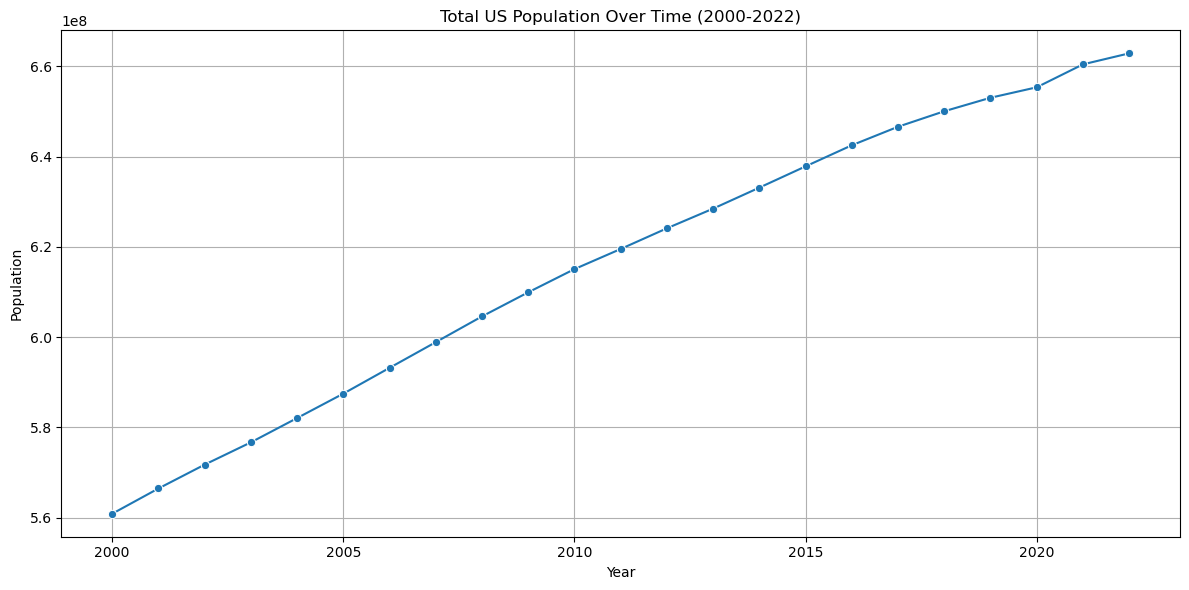

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming combined_df is your merged DataFrame
# Ensure that all POPESTIMATE columns are numeric
pop_columns = [col for col in combined_df.columns if 'POPESTIMATE' in col]
combined_df[pop_columns] = combined_df[pop_columns].apply(pd.to_numeric, errors='coerce')

# Calculate total population per year
total_population = combined_df[pop_columns].sum()

# Extract years from column names
years = [int(col.replace('POPESTIMATE', '')) for col in total_population.index]
pop_values = total_population.values

# Create a DataFrame for plotting
total_pop_df = pd.DataFrame({
    'Year': years,
    'Total Population': pop_values
})

# Plotting
plt.figure(figsize=(12, 6))
sns.lineplot(data=total_pop_df, x='Year', y='Total Population', marker='o')
plt.title('Total US Population Over Time (2000-2022)')
plt.xlabel('Year')
plt.ylabel('Population')
plt.grid(True)
plt.tight_layout()
plt.show()
